<a href="https://colab.research.google.com/github/ngohuongly/Background-removal/blob/main/Remove_background_class_person___Deeplab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We need to do 3 parts: 
1. Background areas selection
2. Filtering
3. Final cleaning

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms 

The first part is to do background areas selection

In [3]:
def make_deeplab(device):
  deeplab= deeplabv3_resnet101(pretrained = True).to(device)
  deeplab.eval()
  return deeplab

device = torch.device("cpu")
deeplab= make_deeplab(device)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


The next step is loading the image for background removal. 

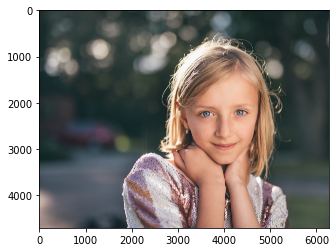

In [5]:
f_name= "/content/gdrive/My Drive/Computer vision project/test2.jpg"
img_orig= cv2.imread(f_name, 1)
plt.imshow(img_orig[:, :, ::-1])
plt.show()

k= min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img=cv2.resize(img_orig, None, fx=k, fy=k, interpolation =cv2.INTER_LANCZOS4)

Select the background on an image

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


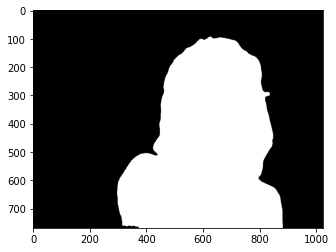

In [6]:
deeplab_preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                                  
])

def apply_deeplab(deeplab, img, device):
  input_tensor = deeplab_preprocess(img)
  input_batch=input_tensor.unsqueeze(0)
  with torch.no_grad():
    output= deeplab(input_batch.to(device))['out'][0]
  output_predictions = output.argmax(0).cpu().numpy()
  return (output_predictions == 15)

mask = apply_deeplab(deeplab, img, device)
mask

plt.imshow(mask, cmap="gray")
plt.show()

Image matting process
1. import the FBA Matting into the image processing script

In [7]:
import sys
sys.path.append("/content/gdrive/My Drive/Computer vision project/FBA_Matting")

from demo import np_to_torch, pred, scale_input
from dataloader import read_image, read_trimap
from networks.models import build_model

2. Configure and load the FBA Model

In [8]:

class Args:
    encoder = 'resnet50_GN_WS'
    decoder = 'fba_decoder'
    weights = 'FBA.pth'
args=Args()
try:
    model = build_model(args)
except:
    !gdown  https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
    model = build_model(args)

modifying input layer to accept 11 channels
Downloading...
From: https://drive.google.com/uc?id=1T_oiKDE_biWf2kqexMEN7ObWqtXAzbB1
To: /content/FBA.pth
139MB [00:02, 68.0MB/s]
modifying input layer to accept 11 channels


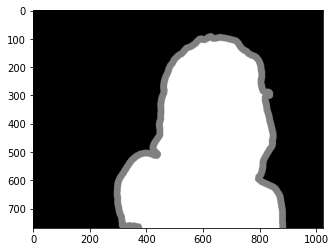

In [9]:

trimap = np.zeros((mask.shape[0], mask.shape[1], 2))
trimap[:, :, 1] = mask > 0
trimap[:, :, 0] = mask == 0
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))

trimap[:, :, 0] = cv2.erode(trimap[:, :, 0], kernel)
trimap[:, :, 1] = cv2.erode(trimap[:, :, 1], kernel)

trimap_im =  trimap[:,:,1] + (1-np.sum(trimap,-1))/2
plt.imshow(trimap_im, cmap='gray', vmin=0, vmax=1)
plt.show()

In [10]:
fg, bg, alpha = pred((img/255.0)[:, :, ::-1], trimap, model)

In [11]:
img_ = img_orig.astype(np.float32)/255
alpha_ = cv2.resize(alpha, (img_.shape[1], img_.shape[0]), cv2.INTER_LANCZOS4)
fg_alpha = np.concatenate([img_, alpha_[:, :, np.newaxis]], axis=2)
cv2.imwrite(f_name + ".png", (fg_alpha*255).astype(np.uint8))

True